In [0]:
import tensorflow.compat.v1 as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
tf.disable_v2_behavior()

In [0]:
batch_size = 10
hidden_layer = 256
clip_margin = 5
learning_rate = 0.001
epochs = 200
time_step=10
window_size=8
train_X,train_Y=[],[]   #訓練集
test_x,test_y=[],[] 

In [78]:
tesla_stocks = pd.read_csv('3037_2010_2019_csv.csv')
labelencoder = LabelEncoder()
tesla_stocks.iloc[:,[1]] = labelencoder.fit_transform(tesla_stocks.iloc[:,[1]])
data_to_use = tesla_stocks.iloc[:,[1,2,3,4,5,6,8,9]].values
ans = tesla_stocks.iloc[:,[7]].values

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 8))
# scaled_ans = scaler.fit_transform(ans) 結果不好

In [80]:
scaled_data.shape

(2372, 8)

In [81]:
X_train = np.array(data_to_use[:2342]).reshape(-1,8,1)#全=2372
y_train = np.array(ans[:2342])
X_test = np.array(data_to_use[2342:]).reshape(-1,8,1)
y_test = np.array(ans[2342:])
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (2342, 8, 1)
y_train size: (2342, 1)
X_test size: (30, 8, 1)
y_test size: (30, 1)


In [0]:
inputs = tf.placeholder(tf.float32, [batch_size,8, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In [0]:
#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev = 0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev = 0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev = 0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev = 0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev = 0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev = 0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev = 0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev = 0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

## Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev = 0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

In [0]:
def LSTM_cell(input, state, output):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output

In [0]:
outputs = []
for i in range(batch_size):
    batch_state = np.zeros([1, hidden_layer], dtype = np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype = np.float32)
    for j in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][j], (-1, 1)), batch_state, batch_output)
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)

In [86]:
inputs

<tf.Tensor 'Placeholder_6:0' shape=(10, 8, 1) dtype=float32>

In [87]:
outputs

[<tf.Tensor 'add_2262:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2335:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2408:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2481:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2554:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2627:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2700:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2773:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2846:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2919:0' shape=(1, 1) dtype=float32>]

In [0]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

In [0]:
# def lr_schedule(epoch):
#     lr = 1e-3
#     if epoch > 100:
#         lr *= 0.5e-3
#     elif epoch > 80:
#         lr *= 1e-3
#     elif epoch > 60:
#         lr *= 1e-2
#     elif epoch > 30:
#         lr *= 1e-1
#     print('Learning rate: ', lr)
#     return lr

# lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
###################################################
# parameters setting
lr0 = 0.001
lr_decay = 0.99
lr_step = 30
global_step = tf.Variable(0)
lr = tf.train.exponential_decay(
        lr0,
        global_step,
        decay_steps=lr_step,
        decay_rate=lr_decay,
        staircase=True)

In [0]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(lr)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

In [0]:
session = tf.Session()

In [0]:
session.run(tf.global_variables_initializer())

In [98]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size].reshape(10,8,1)
        y_batch = y_train[ii:ii+batch_size].reshape(10,1)
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 1) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)),'learning rate:{}'.format(lr))

Epoch 0/200  Current loss: 183.0208740234375 learning rate:Tensor("ExponentialDecay:0", shape=(), dtype=float32)
Epoch 1/200  Current loss: 189.1992645263672 learning rate:Tensor("ExponentialDecay:0", shape=(), dtype=float32)
Epoch 2/200  Current loss: 204.25929260253906 learning rate:Tensor("ExponentialDecay:0", shape=(), dtype=float32)
Epoch 3/200  Current loss: 178.72857666015625 learning rate:Tensor("ExponentialDecay:0", shape=(), dtype=float32)
Epoch 4/200  Current loss: 166.11170959472656 learning rate:Tensor("ExponentialDecay:0", shape=(), dtype=float32)
Epoch 5/200  Current loss: 155.37017822265625 learning rate:Tensor("ExponentialDecay:0", shape=(), dtype=float32)
Epoch 6/200  Current loss: 136.6542205810547 learning rate:Tensor("ExponentialDecay:0", shape=(), dtype=float32)
Epoch 7/200  Current loss: 117.5834732055664 learning rate:Tensor("ExponentialDecay:0", shape=(), dtype=float32)
Epoch 8/200  Current loss: 99.91222381591797 learning rate:Tensor("ExponentialDecay:0", shap

In [99]:
y_batch.shape

(10, 1)

In [0]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [101]:
sup

[array([45.26688], dtype=float32),
 array([44.415657], dtype=float32),
 array([44.244232], dtype=float32),
 array([43.9722], dtype=float32),
 array([43.435642], dtype=float32),
 array([43.522205], dtype=float32),
 array([43.194393], dtype=float32),
 array([42.198185], dtype=float32),
 array([42.92898], dtype=float32),
 array([42.801277], dtype=float32),
 array([42.702038], dtype=float32),
 array([44.65264], dtype=float32),
 array([43.68003], dtype=float32),
 array([42.2841], dtype=float32),
 array([40.444984], dtype=float32),
 array([40.257584], dtype=float32),
 array([39.643776], dtype=float32),
 array([39.228153], dtype=float32),
 array([39.92564], dtype=float32),
 array([38.82694], dtype=float32),
 array([36.58396], dtype=float32),
 array([36.14397], dtype=float32),
 array([36.36065], dtype=float32),
 array([36.6458], dtype=float32),
 array([33.71024], dtype=float32),
 array([32.66632], dtype=float32),
 array([34.31339], dtype=float32),
 array([36.21717], dtype=float32),
 array([36.

In [0]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([outputs], feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [103]:
tests

[[[array([[37.17421]], dtype=float32),
   array([[36.72534]], dtype=float32),
   array([[35.30551]], dtype=float32),
   array([[36.11705]], dtype=float32),
   array([[37.200615]], dtype=float32),
   array([[36.757347]], dtype=float32),
   array([[36.800896]], dtype=float32),
   array([[36.80685]], dtype=float32),
   array([[37.241108]], dtype=float32),
   array([[39.319458]], dtype=float32)]],
 [[array([[40.75426]], dtype=float32),
   array([[40.586834]], dtype=float32),
   array([[39.631714]], dtype=float32),
   array([[39.333847]], dtype=float32),
   array([[40.204334]], dtype=float32),
   array([[40.315147]], dtype=float32),
   array([[39.877377]], dtype=float32),
   array([[38.348972]], dtype=float32),
   array([[37.663486]], dtype=float32),
   array([[36.834446]], dtype=float32)]],
 [[array([[35.49814]], dtype=float32),
   array([[36.016922]], dtype=float32),
   array([[33.964764]], dtype=float32),
   array([[36.8]], dtype=float32),
   array([[37.49797]], dtype=float32),
   array(

In [0]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [105]:
tests

[[[array([[37.17421]], dtype=float32),
   array([[36.72534]], dtype=float32),
   array([[35.30551]], dtype=float32),
   array([[36.11705]], dtype=float32),
   array([[37.200615]], dtype=float32),
   array([[36.757347]], dtype=float32),
   array([[36.800896]], dtype=float32),
   array([[36.80685]], dtype=float32),
   array([[37.241108]], dtype=float32),
   array([[39.319458]], dtype=float32)]],
 [[array([[40.75426]], dtype=float32),
   array([[40.586834]], dtype=float32),
   array([[39.631714]], dtype=float32),
   array([[39.333847]], dtype=float32),
   array([[40.204334]], dtype=float32),
   array([[40.315147]], dtype=float32),
   array([[39.877377]], dtype=float32),
   array([[38.348972]], dtype=float32),
   array([[37.663486]], dtype=float32),
   array([[36.834446]], dtype=float32)]],
 [[array([[35.49814]], dtype=float32),
   array([[36.016922]], dtype=float32),
   array([[33.964764]], dtype=float32),
   array([[36.8]], dtype=float32),
   array([[37.49797]], dtype=float32),
   array(

In [106]:
len(tests_new)

30

In [0]:
test_results = []
for i in range(2372):
    if i >= 2342:
        test_results.append(tests_new[i-2342])
    else:
        test_results.append(None)

In [0]:
# test_results_re = []
# for i in range(2372):
#    if i >= 2342:
#         test_results_re.append(scaler.inverse_transform(tests_new[i-2342]))
#    else:
#        test_results_re.append(None)


In [0]:
tests_count=[]
for i in range(2372):
    if i >= 2342:
      tests_count.append(tests_new[i-2342])


In [111]:
len(test_results)

2372

In [112]:
test_count = np.asarray(tests_count).reshape(30,1)
test_count

array([[37.17421 ],
       [36.72534 ],
       [35.30551 ],
       [36.11705 ],
       [37.200615],
       [36.757347],
       [36.800896],
       [36.80685 ],
       [37.241108],
       [39.319458],
       [40.75426 ],
       [40.586834],
       [39.631714],
       [39.333847],
       [40.204334],
       [40.315147],
       [39.877377],
       [38.348972],
       [37.663486],
       [36.834446],
       [35.49814 ],
       [36.016922],
       [33.964764],
       [36.8     ],
       [37.49797 ],
       [37.726467],
       [36.862545],
       [39.4074  ],
       [38.6925  ],
       [39.085583]], dtype=float32)

In [0]:
y_test

In [114]:
real_data_test =y_test[np.logical_not(np.isnan(y_test))].reshape(30,1)
real_data_test

array([[37.45],
       [37.15],
       [35.3 ],
       [35.8 ],
       [37.5 ],
       [36.7 ],
       [37.2 ],
       [36.85],
       [37.15],
       [39.5 ],
       [40.6 ],
       [41.75],
       [40.2 ],
       [39.5 ],
       [40.6 ],
       [41.15],
       [40.2 ],
       [38.7 ],
       [38.  ],
       [37.25],
       [36.65],
       [35.9 ],
       [35.75],
       [36.35],
       [38.15],
       [38.05],
       [37.1 ],
       [39.  ],
       [39.85],
       [39.25]])

In [115]:
len(real_data_test)

30

In [116]:
 acc = np.sum(np.abs(list(real_data_test[i] - tests_count[i] for i in range(len(real_data_test)))))/len(real_data_test)
 acc

0.44160334269205775

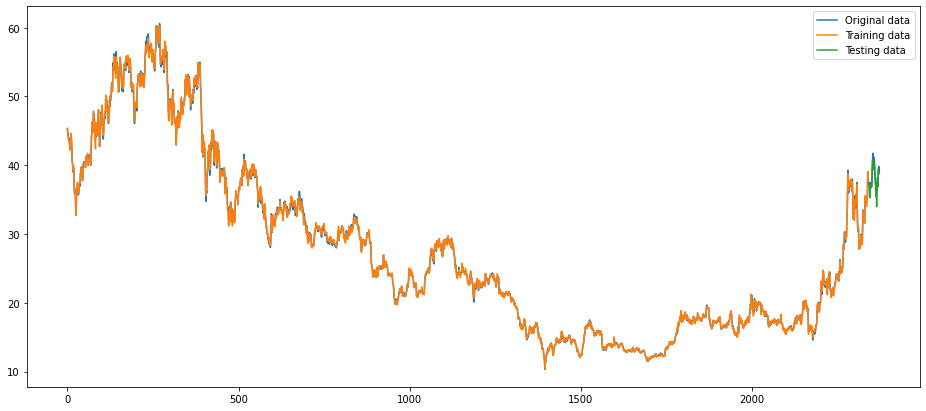

In [117]:
plt.figure(figsize=(16, 7))
plt.plot(ans, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [0]:
# plt.figure(figsize=(16, 7))
# plt.plot(ans, label='Original data')
# plt.plot(scaler.inverse_transform(sup), label='Training data')
# plt.plot(test_results_re, label='Testing data')
# plt.legend()
# plt.show()

In [0]:
# session.close()